### Bibliotecas

In [6]:
import pandas as pd
import numpy as np

from aeon.datasets import load_classification
from aeon.datasets.tsc_data_lists import univariate_equal_length
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier, ShapeDTW, ElasticEnsemble

from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

import pywt

from sklearn.metrics import accuracy_score

from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

from scipy.stats import norm
from scipy.fftpack import fft
from numba import jit
from tqdm import tqdm
import timeit
from datetime import timedelta
#pd.io.parquet.get_engine('auto')
import warnings
warnings.filterwarnings("ignore")

### Dados

In [5]:
"""try:
    train_data = pd.read_parquet('\DS\Parquet_Quali\Car_TRAIN.parquet')
    test_data = pd.read_parquet('\DS\Parquet_Quali\Car_TEST.parquet')
except FileNotFoundError:
    print("Ensure the Parquet files are in the correct path.")
    raise

X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values"""

In [3]:
X_train, y_train = load_classification('CBF', split="TRAIN")
X_test, y_test = load_classification('CBF', split="test")

# Achatando os dados para 2D, pois alguns algoritmos esperam 2D
Xtrain = X_train.reshape(X_train.shape[0], -1)
Xtest = X_test.reshape(X_test.shape[0], -1)

### Função de transformação dos dados.

In [16]:
@jit
def sax_transform(series, w, a):
    paa = [series[i:i + w].mean() for i in range(0, len(series), w)]
    
    if np.std(paa) != 0:
        paa = (paa - np.mean(paa)) / np.std(paa)
    else:
        paa = paa - np.mean(paa)
    
    breakpoints = norm.ppf(np.linspace(0, 1, a+1)[1:-1])
    sax_symbols = np.array(range(a))
    sax_representation = sax_symbols[np.digitize(paa, breakpoints)]
    
    return sax_representation

@jit
def transform_data(X, num_features=10):
    a = 5
    w = int(X.shape[1] / num_features)  # Ajuste do tamanho da janela baseado no número de características desejado
    
    X_sax = np.array([sax_transform(row, w, a) for row in X])
    X_fft = np.abs(fft(X, axis=1))
    
    coeffs_cA, coeffs_cD = pywt.dwt(X, 'db4', axis=1)
    X_dwt = np.hstack((coeffs_cA, coeffs_cD))
    
    X_paa = np.column_stack([X[:, i:i+2].mean(axis=1) for i in range(0, X.shape[1], 2)])

    return {
        "TS": X,
        "FFT": X_fft,
        "DWT": X_dwt,
        "PAA": X_paa,
        "SAX": X_sax
    }

### Seleção do modelo extrator e modelo classificador

In [17]:
@jit
def select_model(option, random_state):
    if option == '1nn':
        return KNeighborsTimeSeriesClassifier(distance='euclidean', n_neighbors=1)
    elif option == '3nn':
        return KNeighborsTimeSeriesClassifier(distance='dtw', n_neighbors=3)
    elif option == 'svm':
        return SVC(C = 100, gamma=0.01, kernel='rbf', probability=True)
    elif option == 'gbc':
        return GradientBoostingClassifier(n_estimators=100, random_state=random_state)
    elif option == 'nb':
        return GaussianNB()
    elif option == 'shape':
        return ShapeDTW(n_neighbors=1)
    elif option == 'ee':
        return ElasticEnsemble(n_jobs=-1,
                               random_state=random_state,
                               majority_vote=True)
    elif option == 'rd':
        return RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    else:
        return RandomForestClassifier(n_estimators=200,
                                    n_jobs=-1,
                                    random_state=random_state)
        #return RandomForestClassifier(n_estimators=100,random_state=random_state)

### Treino do modelos extrator e classificador

In [18]:
"""def train_with_meta_classifier(X_train, y_train, base_option='random_forest', meta_option='1nn', random_state=42):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    
    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino

    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):
        model = select_model(base_option, random_state)
        model.fit(X_trans, y_train)
        trained_models[rep] = model
        
    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, model in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        meta_features.append(instance_features)
    
    meta_features = np.array(meta_features)
    np.savetxt("meta-features-train.csv", meta_features, delimiter=",")
    
    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier"""

'def train_with_meta_classifier(X_train, y_train, base_option=\'random_forest\', meta_option=\'1nn\', random_state=42):\n    trained_models = {}  # Salvar modelos treinados para cada transformação\n    \n    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino\n\n    # Treinar um modelo para cada transformação e salvar no dicionário\n    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):\n        model = select_model(base_option, random_state)\n        model.fit(X_trans, y_train)\n        trained_models[rep] = model\n        \n    # Preparar dados para o meta-classificador\n    meta_features = []\n    for i in range(X_train.shape[0]):\n        instance_features = []\n        for rep, model in trained_models.items():\n            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))\n            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades\n      

In [19]:
@jit
def train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='rf', random_state=42):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    
    X_train_transformed = transform_data(X_train)  # Transformar todo o conjunto de treino
    
    loo = LeaveOneOut()
    
    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in tqdm(X_train_transformed.items(), ascii=True, desc="Training Base Models"):
        model = select_model(base_option, random_state)
        scores = []
        for train_index, _ in loo.split(X_trans):
            model.fit(X_trans[train_index], y_train[train_index])
            score = model.score(X_trans[train_index], y_train[train_index])  # Score do modelo nos dados de treino
            scores.append(score)
        avg_score = np.mean(scores)
        trained_models[rep] = (model, avg_score)  # Salvar o modelo treinado e a média dos scores
        
    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, (model, _) in trained_models.items():
            proba = model.predict_proba(X_train_transformed[rep][i].reshape(1, -1))
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        meta_features.append(instance_features)
    
    meta_features = np.array(meta_features)
    np.savetxt("meta-features-train.csv", meta_features, delimiter=",")
    
    # Treinar o meta-classificador
    meta_classifier = select_model(meta_option, random_state)
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier


### Predicao do meta-classificador

In [20]:
"""def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste
    
    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data(x_instance)
        
        instance_features = []
        for rep, model in trained_base_models.items():
            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        
        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões
        
        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista
    
    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    # Salvar todos os meta-recursos dos dados de teste em um arquivo CSV
    np.savetxt("meta-features-test.csv", meta_features_test, delimiter=",")
    
    return predictions"""


'def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):\n    predictions = []\n    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste\n    \n    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):\n        x_instance = X_test[i].reshape(1, -1)\n        x_transformed = transform_data(x_instance)\n        \n        instance_features = []\n        for rep, model in trained_base_models.items():\n            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento\n            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades\n        \n        meta_feature = np.array(instance_features).reshape(1, -1)\n        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões\n        \n        meta_features_test.append(meta_feature.flatten())  

In [21]:
@jit
def predict_with_meta_classifier(X_test, trained_base_models, trained_meta_classifier):
    predictions = []
    meta_features_test = []  # Inicialize uma lista para armazenar todos os meta-recursos dos dados de teste
    
    for i in tqdm(range(len(X_test)), ascii=True, desc="Testing Instances"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data(x_instance)
        
        instance_features = []
        for rep, (model, _) in trained_base_models.items():  # Ajuste para percorrer os modelos treinados e os scores médios
            proba = model.predict_proba(x_transformed[rep][0].reshape(1, -1))  # Ajuste aqui para pegar o primeiro elemento
            instance_features.extend(proba.flatten())  # Estender a lista com todas as probabilidades
        
        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])  # Adicionar a previsão à lista de previsões
        
        meta_features_test.append(meta_feature.flatten())  # Adicionar meta-recursos da instância atual à lista
    
    # Converter a lista de meta-recursos dos dados de teste em um array numpy
    meta_features_test = np.array(meta_features_test)

    # Salvar todos os meta-recursos dos dados de teste em um arquivo CSV
    np.savetxt("meta-features-test.csv", meta_features_test, delimiter=",")
    
    return predictions


### Testando um único modelo - Random Forest como extrator e SVM como meta-classificador

In [22]:
try:
    train_data = pd.read_parquet('\DS\Parquet_Quali\TwoPatterns_TRAIN.parquet')
    test_data = pd.read_parquet('\DS\Parquet_Quali\TwoPatterns_TEST.parquet')
except FileNotFoundError:
    print("Ensure the Parquet files are in the correct path.")
    raise

X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values

X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values

In [24]:
# Treino

trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='rd', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')


Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
X_train, y_train = load_classification('BirdChicken', split="TRAIN")
X_test, y_test = load_classification('BirdChicken', split="test")

# Achatando os dados para 2D, pois alguns algoritmos esperam 2D
Xtrain = X_train.reshape(X_train.shape[0], -1)
Xtest = X_test.reshape(X_test.shape[0], -1)

In [ ]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(Xtrain, y_train, base_option='ee', meta_option='rd', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(Xtest, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Training Base Models:   0%|          | 0/5 [11:32<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='shape', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)

print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 60/60 [00:00<00:00, 90.96it/s]

Accuracy: 0.7666666666666667


### Testando um único modelo - SVM como extrator e meta-classificador

In [ ]:
# Treino
trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option='1nn', random_state=42)

# Teste
predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)

# Resultado
test_accuracy_meta = np.mean(predictions_test_meta == y_test)
print(f'Accuracy: {test_accuracy_meta}')

Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]

Testing Instances: 100%|##########| 60/60 [00:00<00:00, 135.00it/s]

Accuracy: 0.85


In [ ]:
#Teste utilizando o classificador SVM
meta_attrib_train = np.loadtxt("meta-features-train.csv", delimiter=",")
meta_attrib_test = np.loadtxt("meta-features-test.csv", delimiter=",")
from sklearn.metrics import accuracy_score

clf = SVC(probability=True)
clf.fit(meta_attrib_train, y_train)
y_hat = clf.predict(meta_attrib_test)
test_accuracy_meta = accuracy_score(y_hat, y_test)
print(f"Accuracy: {test_accuracy_meta}")

Accuracy: 0.85


In [ ]:
clf_2 = SVC(probability=True)
clf_2.fit(X_train, y_train)
y_hat_ = clf_2.predict(X_test)
test_accuracy_meta_2 = accuracy_score(y_hat_,y_test)
print(f"Accuracy: {test_accuracy_meta_2}")

Accuracy: 0.5166666666666667


### Gráfico das diferenças de dados

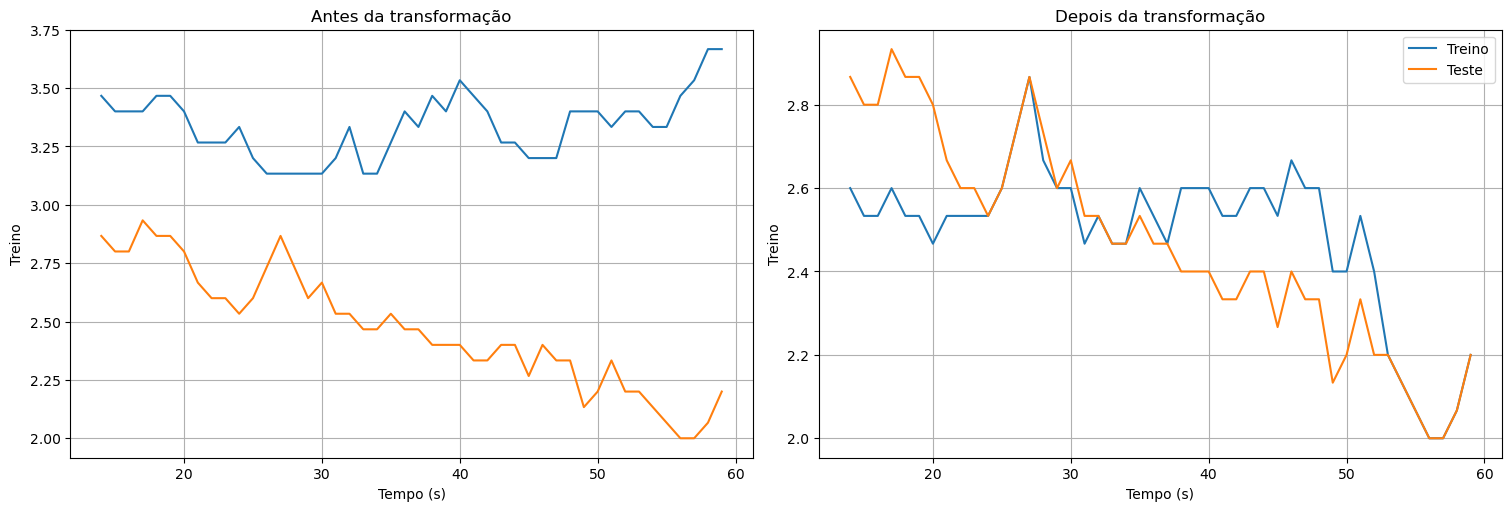

In [ ]:
import matplotlib.pyplot as plt

y1 = y_hat  # depois da transformação
y2 = y_test  

z1 = y_hat_ #antes da transformação
z2 = y_test

#suavizar os dados do gráfico
window_size = 15
y1_smoothed = pd.Series(y1).rolling(window=window_size).mean()
y2_smoothed = pd.Series(y2).rolling(window=window_size).mean()
z1_smoothed = pd.Series(z1).rolling(window=window_size).mean()
z2_smoothed = pd.Series(z2).rolling(window=window_size).mean()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), layout='constrained')

# Conjunto de validação do classificador
axs[0].set_title('Antes da transformação')
axs[0].plot(z1_smoothed, label='Treino')
axs[0].plot(z2_smoothed, label='Teste')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Treino')
axs[0].grid(True)

# Conjunto de validação do meta-classificador
axs[1].set_title('Depois da transformação')
axs[1].plot(y1_smoothed, label='Treino')
axs[1].plot(y2_smoothed, label='Teste')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Treino')
axs[1].grid(True)

plt.legend()
plt.show()



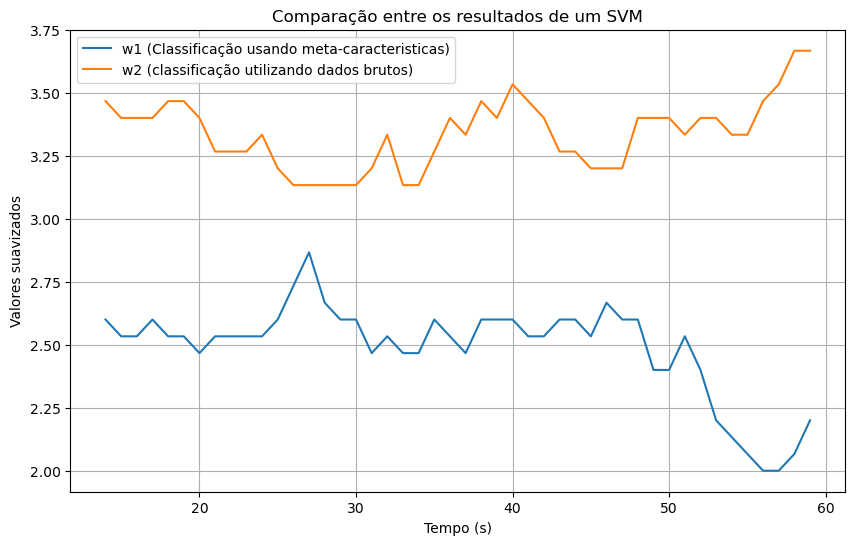

In [ ]:
w1 = y_hat  # meta-classificador
w2 = y_hat_ #classificação

# Suavizar os dados do gráfico
window_size = 15
w1_smoothed = pd.Series(w1).rolling(window=window_size).mean()
w2_smoothed = pd.Series(w2).rolling(window=window_size).mean()

# Plotar os dados
plt.figure(figsize=(10, 6))
plt.plot(w1_smoothed, label='w1 (Classificação usando meta-caracteristicas)')
plt.plot(w2_smoothed, label='w2 (classificação utilizando dados brutos)')
plt.xlabel('Tempo (s)')
plt.ylabel('Valores suavizados')
plt.title('Comparação entre os resultados de um SVM')
plt.legend()
plt.grid(True)
plt.show()


### Treino em loop de todas as opções de classificadores disponiveis no Select Model.

In [ ]:
algos = ['1nn', '3nn', 'svm', 'nb', 'gbc', 'ee', 'shape', 'rf']
for algo in algos:
    
    print(f'Meta-classificador com modelo extrator {algo.upper()}')
    
    # Training
    try:
        trained_base_models, meta_classifier = train_with_meta_classifier(X_train, y_train, base_option='svm', meta_option=algo)
        # Testing
        predictions_test_meta = predict_with_meta_classifier(X_test, trained_base_models, meta_classifier)
        test_accuracy_meta = np.mean(predictions_test_meta == y_test)
        
        print(f'Acurácia do teste usando o meta-classificador com modelo extrator {algo}: {test_accuracy_meta}')
    except Exception as e:
        print(f"Ocorreu um erro no teste com o {algo}: {e}")
    print("-------------------------------")

In [ ]:
dataset_list = ['Adiac', 'Beef', 'Car', 'CBF', 'Coffee', 'DiatomSizeReduction', 'ECG200', 'ECGFiveDays', 'FaceFour',
'GunPoint', 'Lightning2', 'Lightning7', 'MoteStrain', 'OliveOil', 'SonyAIBORobotSurface1','SonyAIBORobotSurface2', 'SyntheticControl']
#'MedicalImages', 'Trace', 'TwoPatterns'
# Para cada conjunto de dados na lista
total_time = 0
#algos = ['1nn', '3nn', 'svm', 'nb', 'gbc', 'ee', 'shape', 'rf', 'rd']
for dataset_name in univariate_equal_length:
    # Carregue os dados de treinamento e teste
    X_train, y_train = load_classification(dataset_name, extract_path="./Temp/", split="TRAIN")
    X_test, y_test = load_classification(dataset_name, extract_path="./Temp/", split="test")
    
    # Achatando os dados para 2D, pois alguns algoritmos esperam 2D
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    dataset_accuracies = []
    #for algo in algos:
    # Treinar o modelo e fazer previsões
    start = timeit.default_timer()
    trained_base_models, meta_classifier = train_with_meta_classifier(X_train_flat, y_train, base_option='svm')
    predictions_test_meta = predict_with_meta_classifier(X_test_flat, trained_base_models, meta_classifier)
    stop = timeit.default_timer()
    total_time += stop - start
    real_time = str(timedelta(seconds=total_time))
    
    # Calcular a acurácia e armazená-la
    test_accuracy_meta = np.mean(predictions_test_meta == y_test)
    dataset_accuracies.append(test_accuracy_meta)
    
    
    print(f"Acurácia do modelo {algo} para {dataset_name}: {test_accuracy_meta}")
    print('Time runtime (seconds): ', real_time)
        
np.savetxt("Results_ALLMSLOO_.csv", dataset_accuracies, delimiter=",")

Testing Instances: 100%|##########| 1380/1380 [00:57<00:00, 24.15it/s]


Acurácia do modelo rf para CinCECGTorso: 0.4753623188405797
Time runtime (seconds):  0:01:01.883961


Testing Instances: 100%|##########| 1252/1252 [00:37<00:00, 33.26it/s]


Acurácia do modelo rf para MoteStrain: 0.8498402555910544
Time runtime (seconds):  0:01:39.992304


Testing Instances: 100%|##########| 362/362 [00:16<00:00, 21.78it/s]


Acurácia do modelo rf para EOGHorizontalSignal: 0.08011049723756906
Time runtime (seconds):  0:45:02.167633


Testing Instances: 100%|##########| 77/77 [00:03<00:00, 24.86it/s]


Acurácia do modelo rf para Worms: 0.5714285714285714
Time runtime (seconds):  0:48:38.328519


Testing Instances: 100%|##########| 60/60 [00:01<00:00, 31.85it/s]


Acurácia do modelo rf para Car: 0.8166666666666667
Time runtime (seconds):  0:48:45.010322


Testing Instances: 100%|##########| 4500/4500 [02:21<00:00, 31.71it/s]


Acurácia do modelo rf para ECG5000: 0.9142222222222223
Time runtime (seconds):  0:58:12.100703


Training Base Models:   0%|          | 0/5 [00:00<?, ?it/s]